# Projet Gustave Malachane Kilian Violet

In [1]:
!py -m pip install requests

In [2]:
import urllib.request
import json
import pandas as pd
import requests
import shutil
import os

def download_image(url, name):

    headers = {"User-Agent": "Mozilla/5.0"}
    request = requests.get(url, allow_redirects=True, headers=headers, stream=True)
    if request.status_code == 200:
        with open("./images/"+name+".jpg", "wb") as image:
            request.raw.decode_content = True
            shutil.copyfileobj(request.raw, image)
    return request.status_code


url = "https://query.wikidata.org/sparql?query=Select%20%3Fvolcan%20%3Fimage%20%3Flabel_pays%20%3Fhauteur%20%3Flabel%20%7B%0A%20%20%3Fvolcan%20wdt%3AP31%20wd%3AQ169358%3B%0A%20%20%20%20%20%20%20%20wdt%3AP18%20%3Fimage%3B%0A%20%20%20%20%20%20%20%20wdt%3AP17%20%3Fpays%3B%0A%20%20%20%20%20%20%20%20wdt%3AP2660%20%3Fhauteur%3B%0A%20%20%20%20%20%20%20%20rdfs%3Alabel%20%3Flabel.%0A%20%20%0A%20%20%3Fpays%20rdfs%3Alabel%20%3Flabel_pays.%0A%20%20%0A%20%20FILTER(lang(%3Flabel)%3D%22en%22%20%26%26%20lang(%3Flabel_pays)%3D%22en%22)%0A%7D%0A%0ALIMIT%20150&format=json"
response = urllib.request.urlopen(url)
responsedata = json.loads(response.read().decode("utf-8"))

array = []
metadata_list = []
i = 1
for data in responsedata["results"]["bindings"]:

    metadata = {
        "nom": data["label"]["value"],
        "hauteur": data["hauteur"]["value"],
        "pays": data["label_pays"]["value"]            
    }

    metadata_list.append(metadata)
    response = download_image(str(data["image"]["value"]).replace("%20", "_").replace("%C3%A1", "a"), metadata["nom"])
    
    i += 1
    
dataframe = pd.DataFrame(array, columns=["label", "image"])

with open("metadata.json", "w", encoding="utf-8") as json_file:
    json.dump(metadata_list, json_file, indent=4, ensure_ascii=False)

## Récupération des données exifs des images

Ici grâce à la librairie PIL & exifread, nous pouvons accéder aux données exifs de l'image. elles sont ensuite stockées dans le fichier JSON metadata.json

In [3]:
!py -m pip install exifread

In [4]:
import os
import json
from PIL import Image
import exifread
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image


def get_dominant_colors(image_path, k=5):
    """ Extrait les k couleurs dominantes d'une image avec K-Means """
    with Image.open(image_path) as img:
        img = img.resize((100, 100))  # Réduire la taille pour accélérer le clustering
        img_array = np.array(img).reshape(-1, 3)  # Convertir en tableau de pixels

    # Clustering des couleurs
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(img_array)

    # Convertir les couleurs en hexadécimal
    colors = ['#%02x%02x%02x' % tuple(map(int, color)) for color in kmeans.cluster_centers_]
    return colors

# Dossier contenant les images
image_folder = "images"

# Parcourir chaque fichier image
for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)

    try:
        # Ouvrir l'image avec PIL
        with Image.open(image_path) as img:
            width, height = img.size
            format_img = img.format

            colors = get_dominant_colors(image_path)

            # Déterminer l'orientation
            if width > height:
                orientation = "Paysage"
            elif height > width:
                orientation = "Portrait"
            else:
                orientation = "Carré"

        # Lire les métadonnées EXIF
        with open(image_path, "rb") as img_file:
            tags = exifread.process_file(img_file, details=False)
            date_creation = tags.get("EXIF DateTimeOriginal", "Inconnu")
            camera_model = tags.get("Image Model", "Inconnu")

        # Stocker les métadonnées dans un dictionnaire
        metadataIndex = next((i for i, md in enumerate(metadata_list) if md["nom"]+".jpg" == image_name), -1)
        
        exif = {
            "nom": image_name,
            "chemin": image_path,
            "taille": f"{width}x{height}",
            "format": format_img,
            "orientation": orientation,
            "date_creation": str(date_creation),
            "modele_camera": str(camera_model),
            "colors": colors,
        }

        metadata_list[metadataIndex]["image"] = exif

    except Exception as e:
        print(f"⚠️ Erreur avec {image_name} : {e}")

# Sauvegarder les métadonnées en JSON
with open("metadata.json", "w", encoding="utf-8") as json_file:
    json.dump(metadata_list, json_file, indent=4, ensure_ascii=False)

print("\n Métadonnées enregistrées dans metadata.json")


c:\Users\gusti\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\gusti\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\gusti\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gusti\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1036, in _

⚠️ Erreur avec Mount Ragang.jpg : Image size (768777555 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.

 Métadonnées enregistrées dans metadata.json


In [5]:
import json
import random

# Charger les volcans depuis un fichier JSON
with open("metadata.json", "r", encoding="utf-8") as f:
    volcans = json.load(f)

# Vérifier le nombre total de volcans
nombre_total_volcans = len(volcans)
print(f"Nombre total de volcans chargés : {nombre_total_volcans}")

# Génération de 50 utilisateurs fictifs
utilisateurs = [
    {"id": i, "nom": f"Utilisateur_{i}", "volcans_consultés": []}
    for i in range(1, 51)
]

# Attribution aléatoire des volcans consultés (en enregistrant uniquement le nom)
for utilisateur in utilisateurs:
    nb_volcans = random.randint(5, 20)  # Chaque utilisateur consulte entre 5 et 20 volcans
    volcans_choisis = random.sample(volcans, min(nb_volcans, nombre_total_volcans))
    
    # Stocker uniquement le nom des volcans
    utilisateur["volcans_consultés"] = [volcan["nom"] for volcan in volcans_choisis]

# Sauvegarde des données dans un fichier JSON
with open("utilisateurs_volcans.json", "w", encoding="utf-8") as f:
    json.dump(utilisateurs, f, indent=4, ensure_ascii=False)

# Affichage d'un aperçu des 5 premiers utilisateurs
print(json.dumps(utilisateurs[:5], indent=4, ensure_ascii=False))  # Afficher les 5 premiers utilisateurs


Nombre total de volcans chargés : 130
[
    {
        "id": 1,
        "nom": "Utilisateur_1",
        "volcans_consultés": [
            "Rinjani",
            "Mount Vesuvius",
            "Antisana volcano",
            "Acotango",
            "Imbabura Volcano",
            "Kronotsky",
            "Gunung Raung",
            "Mount Akutan",
            "Vulcano",
            "Volcán Tajumulco",
            "Mount Apo",
            "Tungurahua volcano",
            "Pular",
            "Mount Kazbek",
            "Otake",
            "Ollagüe",
            "Gunung Slamet",
            "Cerro Paniri",
            "Mount Ragang",
            "Mount Adams"
        ]
    },
    {
        "id": 2,
        "nom": "Utilisateur_2",
        "volcans_consultés": [
            "Licancabur",
            "Opala",
            "Mayon Volcano",
            "Mount Sinabung",
            "Seonginbong",
            "Mount St. Helens",
            "Cayambe",
            "Iztaccihuatl",
            "Am

In [ ]:
#j'ai créé 50 utilisateurs via un script python, et ais ajouter les volcans de manière aléatoire grace à random.

top_orientation [('Paysage', 17), ('Portrait', 1)] top_taille [('Petite', 8), ('Moyenne', 8), ('Grande', 2)] top_pays [('Chile', 5), ('Indonesia', 4), ('Philippines', 3), ('United States', 2), ('Spain', 1)] top_balise [('Mount', 7), ('Licancabur', 2), ('Hibok', 2), ('Salak', 1), ('Llullaillaco', 1)]


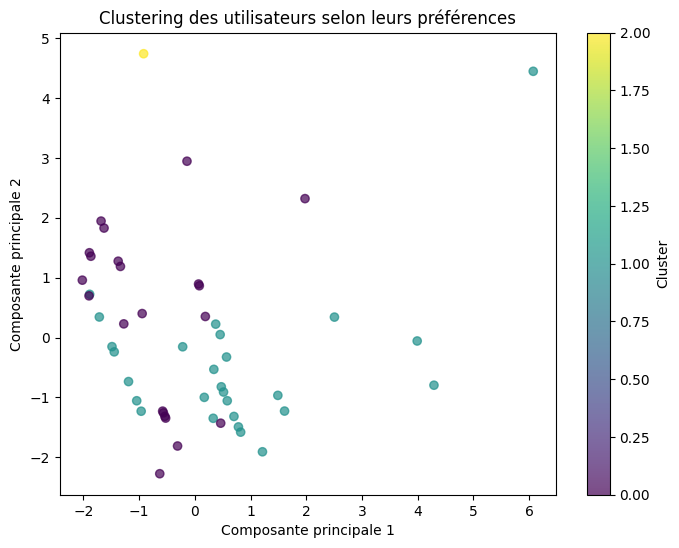

        top_couleur top_orientation top_taille   top_pays top_balise
Cluster                                                             
0           #e2e6e4         Paysage     Grande      Chile      Mount
1           #5a799b         Paysage    Moyenne  Indonesia      Mount
2           #91969e         Paysage     Petite      Chile   Cabalian


In [ ]:
import json
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Charger les données des volcans et des utilisateurs
with open("metadata.json", "r", encoding="utf-8") as f:
    volcans = json.load(f)

with open("utilisateurs_volcans.json", "r", encoding="utf-8") as f:
    utilisateurs = json.load(f)

# Dictionnaires pour stocker les caractéristiques
couleurs_preferees = collections.Counter()
orientation_preferee = collections.Counter()
tailles_images = collections.Counter()
pays_prefere = collections.Counter()
balises_preferees = collections.Counter()

# Création d'une liste pour stocker les données des utilisateurs sous forme de DataFrame
data = []

# Analyse des volcans consultés par les utilisateurs
for utilisateur in utilisateurs:
    user_colors = collections.Counter()
    user_orientations = collections.Counter()
    user_sizes = collections.Counter()
    user_countries = collections.Counter()
    user_tags = collections.Counter()

    for nom_volcan in utilisateur["volcans_consultés"]:
        # Trouver le volcan correspondant
        volcan_data = next((v for v in volcans if v["nom"] == nom_volcan), None)
        if volcan_data:
            if volcan_data and "image" in volcan_data:  # Vérifie si 'image' existe
                # 1. Couleurs préférées
                user_colors.update(volcan_data["image"].get("colors", []))  # .get() évite l'erreur si 'colors' n'existe pas

                # 2. Orientation préférée
                user_orientations[volcan_data["image"].get("orientation", "Inconnu")] += 1

                # 3. Taille d’image préférée
                if "taille" in volcan_data["image"]:
                    largeur, hauteur = map(int, volcan_data["image"]["taille"].split("x"))
                    if largeur < 1000:
                        user_sizes["Petite"] += 1
                    elif largeur < 3000:
                        user_sizes["Moyenne"] += 1
                    else:
                        user_sizes["Grande"] += 1

            # 4. Pays préféré
            user_countries[volcan_data["pays"]] += 1

            # 5. Balises favorites (extraction de mots-clés)
            mots_cles = volcan_data["nom"].replace("-", " ").replace("_", " ").split()
            user_tags.update(mots_cles)

    # Ajouter les données de l'utilisateur sous forme de dictionnaire
    data.append({
        "id": utilisateur["id"],
        "top_couleur": user_colors.most_common(1)[0][0] if user_colors else "None",
        "top_orientation": user_orientations.most_common(1)[0][0] if user_orientations else "None",
        "top_taille": user_sizes.most_common(1)[0][0] if user_sizes else "None",
        "top_pays": user_countries.most_common(1)[0][0] if user_countries else "None",
        "top_balise": user_tags.most_common(1)[0][0] if user_tags else "None"
    })
    
print(        "top_orientation", user_orientations.most_common(5) if user_orientations else "None",
        "top_taille", user_sizes.most_common(5) if user_sizes else "None",
        "top_pays", user_countries.most_common(5) if user_countries else "None",
        "top_balise", user_tags.most_common(5) if user_tags else "None")
# Convertir en DataFrame pandas
df = pd.DataFrame(data)
print(df)
# Encodage des variables catégorielles
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(df[["top_orientation", "top_taille", "top_pays", "top_balise"]]).toarray()

# Normalisation des couleurs (encodage en valeurs numériques)
color_mapping = {color: i for i, color in enumerate(set(df["top_couleur"]))}
df["top_couleur_num"] = df["top_couleur"].map(color_mapping)

# Création du vecteur final de caractéristiques
X = np.hstack([df[["top_couleur_num"]].values, encoded_features])

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Réduction de dimension avec PCA pour visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Clustering avec KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df["Cluster"] = clusters

# Affichage des clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap="viridis", alpha=0.7)
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.title("Clustering des utilisateurs selon leurs préférences")
plt.colorbar(label="Cluster")
plt.show()

# Affichage des résultats
print(df.groupby("Cluster").agg({
    "top_couleur": lambda x: x.value_counts().idxmax(),
    "top_orientation": lambda x: x.value_counts().idxmax(),
    "top_taille": lambda x: x.value_counts().idxmax(),
    "top_pays": lambda x: x.value_counts().idxmax(),
    "top_balise": lambda x: x.value_counts().idxmax()
}))


In [19]:
import json
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

# 1️⃣ Load JSON files
with open("utilisateurs_volcans.json", "r", encoding="utf-8") as f:
    users = json.load(f)  # Users file contains user ID + assigned volcano names

with open("metadata.json", "r", encoding="utf-8") as f:
    volcanoes = json.load(f)  # Contains details about each volcano

# 2️⃣ Create a dictionary for fast lookup of volcano details by name
volcano_dict = {volcano["nom"]: volcano for volcano in volcanoes}

# 3️⃣ Extract features for each user
user_data = []

for user in users:
    user_id = user["id"]
    assigned_volcano_names = user["volcans_consultés"]  # Volcanoes assigned to this user

    couleurs, orientations, tailles, pays, balises = [], [], [], [], []

    for volcan_name in assigned_volcano_names:
        if volcan_name in volcano_dict:  # Ensure volcano exists in data
            volcan = volcano_dict[volcan_name]

            if "image" in volcan:
                couleurs.extend(volcan["image"].get("colors", []))
                orientations.append(volcan["image"].get("orientation", "Inconnu"))

                # Process image size
                if "taille" in volcan["image"]:
                    largeur, _ = map(int, volcan["image"]["taille"].split("x"))
                    if largeur < 1000:
                        tailles.append("Petite")
                    elif largeur < 3000:
                        tailles.append("Moyenne")
                    else:
                        tailles.append("Grande")

            pays.append(volcan.get("pays", "Inconnu"))
            balises.append(volcan["nom"].split()[0])  # First word of
